# Confirm Optimization Results with Real Data

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import requests
import cvxpy as cp

plt.rcParams['figure.figsize'] = (9, 4)
plt.rcParams['axes.grid'] = True

## Load data

### Kalshi real-data integration (unauthenticated)

This notebook can pull **live market prices** from Kalshi without an API key using the base URL:

`KALSHI_BASE_URL = "https://api.elections.kalshi.com/trade-api/v2"`

#### What we fetch

- **Market list (discovery)**: `GET /markets?series_ticker=...&status=open`
  - Used to find valid `MARKET_TICKER`s inside a `SERIES_TICKER`.
- **Market snapshot (fast)**: `GET /markets/{market_ticker}` *(with a fallback to `GET /markets?ticker=...`)*
  - Used to read `yes_price` in cents (interpreted as probability).
- **Orderbook (optional)**: `GET /markets/{market_ticker}/orderbook`
  - Used only if `PRICE_SOURCE = "orderbook_mid"` to compute an approximate mid-price.

All requests are simple `requests.get(...)` calls (no auth headers).

## Choosing a market

Kalshi organizes markets into *series* (e.g. `KXHIGHNY`). Each individual tradable contract has its own `MARKET_TICKER` (e.g. `KXHIGHNY-25DEC17-B43.5`).

In the load cell:

- Set `SERIES_TICKER` to the category we care about.
- Leave `MARKET_TICKER = None` to let the notebook:
  - call `kalshi_get_markets(SERIES_TICKER)`
  - display the resulting table (tickers, titles, volume, etc.)
  - auto-select the **highest-volume** ticker as a reasonable default.

If we already know wer target ticker, set `MARKET_TICKER` explicitly to skip the discovery

## From Kalshi prices to model inputs

#### `p_i` (market price / implied probability)

- With `PRICE_SOURCE = "yes_price"` (default):
  - we read `yes_price` from the market snapshot (quoted in **cents**)
  - convert to probability via `p = yes_price_cents / 100`.

- With `PRICE_SOURCE = "orderbook_mid"`:
  - we fetch the orderbook and compute an approximate mid using the best YES bid and the implied YES price from the best NO bid (`100 - best_no`).

#### `kalshi_snapshot` vs `kalshi_poll`

- `DATA_MODE = "kalshi_snapshot"` gives us **one** price point (quick sanity check).
- `DATA_MODE = "kalshi_poll"` samples repeatedly (`POLL_SAMPLES`, `POLL_INTERVAL_SECONDS`) to form a short time-series `p_1,\dots,p_n`.
  - This is needed for turnover terms `|u_i-u_{i-1}|` and the concavity/subgradient checks.

#### `q_i` (our forecast)

To run the optimization we need a forecast probability series `q_i`. In this notebook we use the simplest baseline:

- **Constant belief:** set `Q0` and define `q_i = Q0` for all `i`.

Finally, the notebook computes:

- `y_i = q_i - p_i`
- `sigma_i^2 = p_i(1-p_i)` (Bernoulli variance proxy for unresolved binary outcome)

In [99]:
# Data mode options:
# - kalshi_snapshot: one-time fetch of current price for a market ticker
# - kalshi_poll: poll Kalshi unauthenticated API for a single market to build a short p_t series
# - proxy_yfinance: optional fallback proxy data (requires yfinance)
DATA_MODE = 'kalshi_poll'

# Kalshi modes
KALSHI_BASE_URL = 'https://api.elections.kalshi.com/trade-api/v2'
SERIES_TICKER = 'KXLLMCHESS'  # helper for discovering markets
MARKET_TICKER = None  # if None, auto-select a high-volume market from SERIES_TICKER
PRICE_SOURCE = 'yes_price'  # 'yes_price' (fast) or 'orderbook_mid'

# Polling defaults are intentionally short so the notebook doesn't "hang".
POLL_SAMPLES = 12
POLL_INTERVAL_SECONDS = 1.0

# Forecast construction (q): constant belief
Q0 = 0.05

def kalshi_get_json(path: str, params: dict | None = None) -> dict:
    url = f"{KALSHI_BASE_URL}{path}"
    resp = requests.get(url, params=params, timeout=30)
    if resp.status_code >= 400:
        msg = resp.text
        raise RuntimeError(f"Kalshi request failed: {resp.status_code} {resp.reason} for {url}. Body: {msg[:500]}")
    return resp.json()


def extract_market_obj(payload: dict) -> dict:
    if payload is None:
        return {}

    if isinstance(payload, dict) and 'error' in payload and payload['error']:
        return {}

    if isinstance(payload, dict) and 'market' in payload and isinstance(payload['market'], dict):
        return payload['market']

    if isinstance(payload, dict):
        markets = payload.get('markets', None)
        if isinstance(markets, list) and len(markets) > 0 and isinstance(markets[0], dict):
            return markets[0]

    return {}


def kalshi_get_markets(series_ticker: str, status: str = 'open', limit: int = 50) -> pd.DataFrame:
    payload = kalshi_get_json('/markets', params={'series_ticker': series_ticker, 'status': status})
    markets = payload.get('markets', []) if isinstance(payload, dict) else []
    if not isinstance(markets, list):
        markets = []

    dfm = pd.DataFrame(markets)
    if dfm.empty:
        return dfm

    cols = [c for c in ['ticker', 'title', 'event_ticker', 'yes_price', 'volume', 'open_time', 'close_time', 'expiration_time', 'status'] if c in dfm.columns]
    dfm = dfm[cols]
    return dfm.head(limit)


def kalshi_get_market_snapshot(market_ticker: str) -> dict:
    try:
        return kalshi_get_json(f"/markets/{market_ticker}")
    except Exception:
        return kalshi_get_json("/markets", params={"ticker": market_ticker})


def kalshi_get_orderbook(market_ticker: str) -> dict:
    return kalshi_get_json(f"/markets/{market_ticker}/orderbook")


def orderbook_mid_prob(orderbook_json: dict) -> float:
    ob = orderbook_json.get('orderbook', {}) if isinstance(orderbook_json, dict) else {}
    yes = ob.get('yes', [])
    no = ob.get('no', [])

    yes_prices = [float(x[0]) for x in yes if isinstance(x, (list, tuple)) and len(x) >= 1]
    no_prices = [float(x[0]) for x in no if isinstance(x, (list, tuple)) and len(x) >= 1]

    if len(yes_prices) == 0 and len(no_prices) == 0:
        return np.nan

    best_yes = max(yes_prices) if len(yes_prices) else np.nan
    implied_yes_from_no = 100.0 - (max(no_prices) if len(no_prices) else np.nan)

    candidates = [v for v in [best_yes, implied_yes_from_no] if np.isfinite(v)]
    if len(candidates) == 0:
        return np.nan

    mid_cents = float(np.mean(candidates))
    return float(np.clip(mid_cents / 100.0, 0.0, 1.0))


def kalshi_price_now(market_ticker: str, price_source: str) -> float:
    if price_source == 'orderbook_mid':
        ob = kalshi_get_orderbook(market_ticker)
        return orderbook_mid_prob(ob)

    snap = kalshi_get_market_snapshot(market_ticker)
    market = extract_market_obj(snap)

    yes_price_cents = market.get('yes_price', None)
    if yes_price_cents is None:
        yes_price_cents = market.get('yes_ask', None)

    if yes_price_cents is None:
        return np.nan

    return float(np.clip(float(yes_price_cents) / 100.0, 0.0, 1.0))


def kalshi_poll_prices(market_ticker: str, samples: int, interval_seconds: float, price_source: str) -> pd.DataFrame:
    rows = []
    errors = []

    try:
        for k in range(samples):
            t = pd.Timestamp.utcnow()
            p = np.nan
            try:
                p = kalshi_price_now(market_ticker, price_source=price_source)
            except Exception as e:
                errors.append(str(e))

            rows.append({'timestamp': t, 'p': p})

            if (k + 1) in (1, samples) or (k + 1) % max(1, samples // 4) == 0:
                print(f"sample {k+1}/{samples}: p={p}")

            time.sleep(interval_seconds)
    except KeyboardInterrupt:
        print('Polling interrupted by user; returning collected samples so far.')

    dfp = pd.DataFrame(rows).set_index('timestamp')
    dfp_clean = dfp.dropna()

    if dfp_clean.empty:
        err_preview = "\n".join(errors[-3:]) if errors else "(no HTTP errors; response may not contain yes_price)"
        raise ValueError(
            "No valid price samples were collected from Kalshi.\n\n"
            "Recommended fix:\n"
            "- Use the printed markets table (or run kalshi_get_markets(SERIES_TICKER)) and set MARKET_TICKER.\n\n"
            "Details:\n"
            f"- base_url={KALSHI_BASE_URL}\n"
            f"- market_ticker={market_ticker}\n"
            f"- price_source={price_source}\n\n"
            "Recent errors / hints:\n"
            f"{err_preview}"
        )

    return dfp_clean


def load_proxy_data_yfinance(ticker='SPY', period='2y') -> pd.DataFrame:
    try:
        import yfinance as yf
    except Exception as e:
        raise RuntimeError('Fallback mode requires yfinance. Install it or use Kalshi modes.') from e

    px = yf.download(ticker, period=period, auto_adjust=True, progress=False)
    if px.empty:
        raise RuntimeError('No data downloaded. Use Kalshi modes instead.')
    close = px['Close'].astype(float)

    r = close.pct_change().fillna(0.0)
    mom = r.rolling(10).mean().fillna(0.0)
    p = (0.5 + 5.0 * mom).clip(0.01, 0.99)

    mom2 = r.rolling(20).mean().fillna(0.0)
    q = (0.5 + 6.0 * mom2).clip(0.01, 0.99)

    out = pd.DataFrame({'p': p, 'q': q}).dropna()
    return out


def ensure_forecast_q(df_in: pd.DataFrame) -> pd.DataFrame:
    df_out = df_in.copy()
    if 'q' in df_out.columns and df_out['q'].notna().all():
        return df_out

    q = pd.Series(float(Q0), index=df_out.index)
    df_out['q'] = q.clip(0.0, 1.0)
    return df_out


# If MARKET_TICKER isn't set, print candidates and auto-select the highest-volume one.
if MARKET_TICKER is None and DATA_MODE in ('kalshi_snapshot', 'kalshi_poll'):
    print('MARKET_TICKER is None. Here are some markets we can use:')
    dfm = kalshi_get_markets(SERIES_TICKER)
    display(dfm)

    if dfm is None or dfm.empty or 'ticker' not in dfm.columns:
        raise ValueError('Could not list markets for SERIES_TICKER. Try a different SERIES_TICKER.')

    dfm2 = dfm.copy()
    if 'volume' in dfm2.columns:
        dfm2['volume'] = pd.to_numeric(dfm2['volume'], errors='coerce').fillna(0)
        dfm2 = dfm2.sort_values('volume', ascending=False)

    MARKET_TICKER = str(dfm2.iloc[0]['ticker'])
    print(f"Auto-selected MARKET_TICKER={MARKET_TICKER}")


if DATA_MODE == 'kalshi_snapshot':
    p0 = kalshi_price_now(MARKET_TICKER, price_source=PRICE_SOURCE)
    if not np.isfinite(p0):
        raise ValueError('Could not read a valid price from Kalshi for the given MARKET_TICKER. Try PRICE_SOURCE="orderbook_mid" or pick a different ticker.')
    df = pd.DataFrame({'p': [p0]}, index=[pd.Timestamp.utcnow()])
elif DATA_MODE == 'kalshi_poll':
    df = kalshi_poll_prices(
        market_ticker=MARKET_TICKER,
        samples=POLL_SAMPLES,
        interval_seconds=POLL_INTERVAL_SECONDS,
        price_source=PRICE_SOURCE,
    )
else:
    df = load_proxy_data_yfinance()

# Ensure we always have both p and q
if 'q' not in df.columns:
    df = ensure_forecast_q(df)
else:
    df = ensure_forecast_q(df)

# Basic sanity
df['p'] = df['p'].astype(float).clip(0.0, 1.0)
df['q'] = df['q'].astype(float).clip(0.0, 1.0)
df = df.dropna()

df.head(), DATA_MODE, df.shape

MARKET_TICKER is None. Here are some markets we can use:


,ticker,title,event_ticker,volume,open_time,close_time,expiration_time,status
0,KXLLMCHESS-26,Will it be reported that an LLM has beat a gra...,KXLLMCHESS-26,87568,2025-03-19T14:00:00Z,2026-01-01T15:00:00Z,2026-01-01T15:00:00Z,active


Auto-selected MARKET_TICKER=KXLLMCHESS-26
sample 1/12: p=0.02
sample 3/12: p=0.02
sample 6/12: p=0.02
sample 9/12: p=0.02
sample 12/12: p=0.02


(                                     p     q
 timestamp                                   
 2025-12-19 03:42:03.223582+00:00  0.02  0.05
 2025-12-19 03:42:05.585918+00:00  0.02  0.05
 2025-12-19 03:42:07.798283+00:00  0.02  0.05
 2025-12-19 03:42:10.108933+00:00  0.02  0.05
 2025-12-19 03:42:12.667275+00:00  0.02  0.05,
 'kalshi_poll',
 (12, 2))

In [100]:
# Model inputs
if df is None or df.empty:
    raise ValueError('No data loaded (df is empty). Fix the Load data cell (ticker/API/CSV) and re-run.')

# Need at least 2 time steps for meaningful turnover terms and concavity checks.
if len(df) < 2:
    raise ValueError(f'Need at least 2 data points, got n={len(df)}. Use DATA_MODE="kalshi_poll" to collect more samples.')

# Clearer naming: market_prob = p_i, forecast_prob = q_i
market_prob = df['p'].to_numpy(dtype=float)
forecast_prob = df['q'].to_numpy(dtype=float)

# Edge (expected advantage): y_i = q_i - p_i
edge = forecast_prob - market_prob

# Variance proxy for unresolved binary payoff: var(Bernoulli(p)) = p(1-p)
variance_proxy = market_prob * (1.0 - market_prob)
variance_proxy = np.clip(variance_proxy, 1e-6, None)

num_steps = len(df)
num_steps

12

## Solve the primal problem (CVXPY)

In [101]:
def solve_primal(edge, variance_proxy, initial_position, risk_aversion=5.0, transaction_cost=0.01, solver=None):
    n = len(edge)
    positions = cp.Variable(n)

    u0 = initial_position
    u_terminal = 0.0

    obj_terms = []
    for i in range(n):
        prev = u0 if i == 0 else positions[i-1]
        obj_terms.append(
            edge[i] * positions[i]
            - risk_aversion * variance_proxy[i] * cp.square(positions[i])
            - transaction_cost * cp.abs(positions[i] - prev)
        )
    obj_terms.append(-transaction_cost * cp.abs(u_terminal - positions[n-1]))

    problem = cp.Problem(cp.Maximize(cp.sum(obj_terms)), [positions >= 0])

    kwargs = {}
    if solver is not None:
        kwargs['solver'] = solver
    problem.solve(**kwargs)
    return {
        'value': float(problem.value),
        'u': np.array(positions.value).reshape(-1),
        'status': problem.status,
    }

# parameters
risk_aversion = 5.0
transaction_cost = 0.01
initial_position = 100  # defined in cents, for $1

pr = solve_primal(edge, variance_proxy, initial_position=initial_position, risk_aversion=risk_aversion, transaction_cost=transaction_cost)
pr['status'], pr['value'], pr['u'][:5]

('optimal',
 -0.9724489795918373,
 array([0.15306122, 0.15306122, 0.15306122, 0.15306122, 0.15306122]))

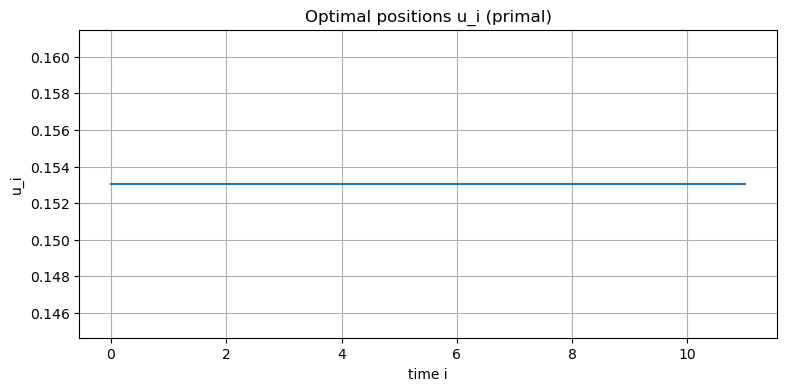

In [102]:
plt.plot(pr['u'])
plt.title('Optimal positions u_i (primal)')
plt.xlabel('time i')
plt.ylabel('u_i')
plt.show()


## Solve the dual problem (CVXPY)

In [103]:
def solve_dual(edge, variance_proxy, initial_position, risk_aversion=5.0, transaction_cost=0.01, solver=None):
    n = len(edge)
    # z_1,...,z_{n+1}
    z = cp.Variable(n + 1)

    # a_i = y_i - z_i + z_{i+1} (1-indexed in the report)
    a = edge - z[:n] + z[1:]

    # (a_i)_+^2 / (4 risk_aversion variance_proxy_i)
    dual_terms = cp.sum(cp.square(cp.pos(a)) / (4.0 * risk_aversion * variance_proxy))
    obj = cp.Minimize(z[0] * initial_position + dual_terms)

    constraints = [cp.abs(z) <= transaction_cost]
    problem = cp.Problem(obj, constraints)

    kwargs = {}
    if solver is not None:
        kwargs['solver'] = solver
    problem.solve(**kwargs)

    return {
        'value': float(problem.value),
        'z': np.array(z.value).reshape(-1),
        'status': problem.status,
    }

du = solve_dual(edge, variance_proxy, initial_position=initial_position, risk_aversion=risk_aversion, transaction_cost=transaction_cost)
du['status'], du['value'], du['z'][:5]

('optimal', -0.9724489795918367, array([-0.01, -0.01, -0.01, -0.01, -0.01]))

In [104]:
gap = abs(pr['value'] - du['value'])
rel_gap = gap / max(1.0, abs(pr['value']), abs(du['value']))
gap, rel_gap


(5.551115123125783e-16, 5.551115123125783e-16)

## Concavity of the value function in w

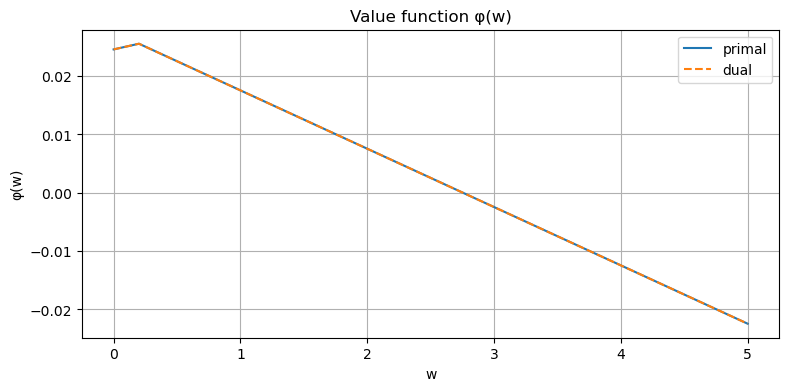

In [105]:
initial_position_grid = np.linspace(0.0, 5.0, 26)
primal_values = []
dual_values = []
z1_star = []

for w_i in initial_position_grid:
    pr_i = solve_primal(edge, variance_proxy, initial_position=w_i, risk_aversion=risk_aversion, transaction_cost=transaction_cost)
    du_i = solve_dual(edge, variance_proxy, initial_position=w_i, risk_aversion=risk_aversion, transaction_cost=transaction_cost)
    primal_values.append(pr_i['value'])
    dual_values.append(du_i['value'])
    z1_star.append(du_i['z'][0])

primal_values = np.array(primal_values)
dual_values = np.array(dual_values)
z1_star = np.array(z1_star)

plt.plot(initial_position_grid, primal_values, label='primal')
plt.plot(initial_position_grid, dual_values, '--', label='dual')
plt.title('Value function φ(w)')
plt.xlabel('w')
plt.ylabel('φ(w)')
plt.legend()
plt.show()

In [106]:
# Discrete concavity check: second differences should be <= 0
second_diff = primal_values[:-2] - 2 * primal_values[1:-1] + primal_values[2:]
second_diff.max(), second_diff.min()

(6.938893903907228e-18, -0.0029761904761904795)

## Notes

- This notebook uses **unauthenticated** Kalshi endpoints to pull prices, so it does not require API keys.
- `kalshi_poll` produces a short, local time-series by polling while the notebook runs. If weneed true historical time-series, we would need a separate data collection step.
- Forecast used in this notebook:
  - Constant belief `q_i = Q0` (a simple subjective probability baseline).